<a href="https://colab.research.google.com/github/aliabdelmageed/YOLOv3-TensorFlow-2.0/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/yolov3-tf2/

/gdrive/My Drive/yolov3-tf2


In [ ]:
# Download yolov3.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights

In [ ]:
#covert weight file into tf format
!python convert_weights.py

#Load model 

In [ ]:
import tensorflow as tf
from utils import load_class_names, output_boxes, draw_outputs, resize_image, imShow, upload
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from yolov3 import YOLOv3Net
%matplotlib inline

#If you don't have enough GPU hardware device available in your machine, uncomment the following three lines:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
model_size = (416, 416,3)
num_classes = 80
class_name = './data/coco.names'
max_output_size = 100
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5


cfgfile = 'cfg/yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
model = YOLOv3Net(cfgfile,model_size,num_classes)

model.load_weights(weightfile)

class_names = load_class_names(class_name)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_3 (TensorFl [(None, 416, 416, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_RealDiv_3[0][0]      
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
____________________________________________________________________________________________

#Test on images

In [ ]:
def detect_img(image_path):

  image = cv2.imread(image_path)
  image = np.array(image)
  image = tf.expand_dims(image, 0)

  resized_frame = resize_image(image, (model_size[0],model_size[1]))
  pred = model.predict(resized_frame)

  boxes, scores, classes, nums = output_boxes( \
      pred, model_size,
      max_output_size=max_output_size,
      max_output_size_per_class=max_output_size_per_class,
      iou_threshold=iou_threshold,
      confidence_threshold=confidence_threshold)
  
  #draw bbox on org image
  image = np.squeeze(image)
  image = draw_outputs(image, boxes, scores, classes, nums, class_names)
  detected_img = image_path[:-4]+'-prediction.png'
  cv2.imwrite(detected_img, image)
  imShow(detected_img)

Saving dog.jpg to dog.jpg
saved file dog.jpg


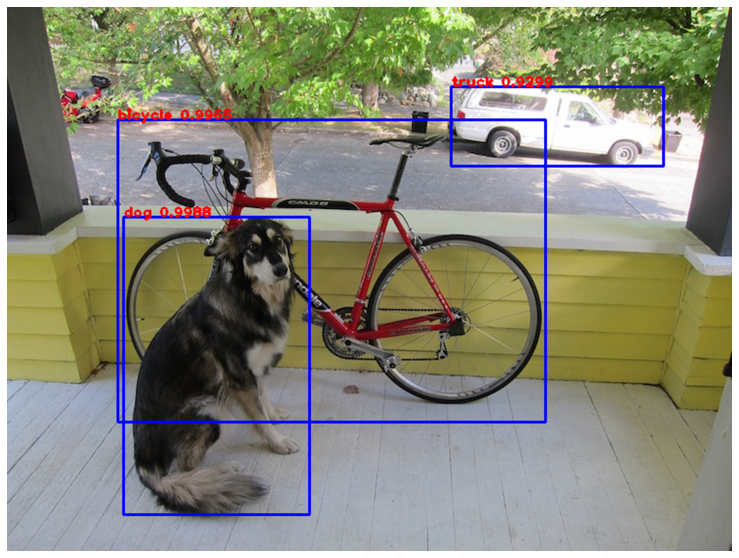

In [ ]:
#detect image
image_path = upload()
detect_img(image_path)

#Test on video

In [ ]:
def detect_vid(video_path):
  
    output = video_path[:-4]+"-detection.avi"
    try:
        vid = cv2.VideoCapture(int(video_path))
    except:
        vid = cv2.VideoCapture(video_path)
    out = None

    # by default VideoCapture returns float instead of int
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    #codec = cv2.VideoWriter_fourcc('mp4')
    out = cv2.VideoWriter(output, fourcc, fps, (width, height))

    while True:
        return_value, frame = vid.read()
        if return_value:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(frame)
        else:
            print('Video has ended or failed, try a different video format!')
            break
        start_time = time.time()
        #drawing_array = np.zeros([416,416,4], dtype=np.uint8)
        resized_frame = tf.expand_dims(frame, 0)
        resized_frame = resize_image(resized_frame, (model_size[0],model_size[1]))

        pred = model.predict(resized_frame)

        boxes, scores, classes, nums = output_boxes( \
            pred, model_size,
            max_output_size=max_output_size,
            max_output_size_per_class=max_output_size_per_class,
            iou_threshold=iou_threshold,
            confidence_threshold=confidence_threshold)

        image = draw_outputs(frame, boxes, scores, classes, nums, class_names)
        #drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255
        fps = 1.0 / (time.time() - start_time)
        print("FPS: %.2f" % fps)      

        result = np.asarray(image)
        result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      
        out.write(result)

In [ ]:
vid_path = 'video.mp4'
detect_vid(vid_path)

FPS: 6.12
FPS: 6.22
FPS: 6.20
FPS: 6.51
FPS: 6.82
FPS: 6.89
FPS: 7.07
FPS: 7.20
FPS: 7.21
FPS: 6.70
FPS: 7.31
FPS: 7.22
FPS: 7.43
FPS: 7.51
FPS: 7.60
FPS: 7.57
FPS: 7.43
FPS: 7.63
FPS: 7.87
FPS: 7.68
FPS: 7.87
FPS: 8.02
FPS: 8.07
FPS: 7.94
FPS: 7.81
FPS: 7.93
FPS: 8.12
FPS: 7.81
FPS: 8.18
FPS: 7.76
FPS: 8.13
FPS: 7.69
FPS: 7.76
FPS: 7.93
FPS: 7.96
FPS: 7.95
FPS: 7.90
FPS: 7.98
FPS: 7.86
FPS: 7.26
FPS: 7.80
FPS: 7.88
FPS: 7.79
FPS: 7.86
FPS: 7.80
FPS: 7.66
FPS: 7.27
FPS: 7.40
FPS: 7.84
FPS: 7.37
FPS: 7.79
FPS: 7.93
FPS: 8.01
FPS: 7.83
FPS: 7.55
FPS: 7.88
FPS: 7.88
FPS: 8.01
FPS: 8.00
FPS: 7.43
FPS: 7.95
FPS: 7.85
FPS: 7.90
FPS: 7.95
FPS: 8.00
FPS: 7.87
FPS: 7.98
FPS: 7.90
FPS: 7.82
FPS: 7.55
FPS: 7.39
FPS: 7.53
FPS: 7.69
FPS: 7.79
FPS: 8.01
FPS: 8.13
FPS: 7.98
FPS: 7.58
FPS: 8.12
FPS: 7.70
FPS: 8.06
FPS: 8.04
FPS: 8.13
FPS: 8.05
FPS: 7.60
FPS: 8.07
FPS: 7.89
FPS: 7.99
FPS: 7.88
FPS: 7.39
FPS: 7.69
FPS: 7.30
FPS: 7.21
FPS: 7.24
FPS: 7.92
FPS: 7.91
FPS: 8.10
FPS: 7.88
FPS: 7.83
FPS: 7.06


#Realtime video

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

In [ ]:
def get_drawing_array(image_array): 
    """
    input: 
          image_array: image array RGB size 512 x 512 from webcam

    output: 
          drawing_array: image RGBA size 512 x 512 only contain bounding box and text, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
    """
    start = time.time()
    drawing_array = np.zeros([416,416,4], dtype=np.uint8)
    resized_frame = tf.expand_dims(image_array, 0)
    resized_frame = resize_image(resized_frame, (model_size[0],model_size[1]))

    pred = model.predict(resized_frame)

    boxes, scores, classes, nums = output_boxes( \
        pred, model_size,
        max_output_size=max_output_size,
        max_output_size_per_class=max_output_size_per_class,
        iou_threshold=iou_threshold,
        confidence_threshold=confidence_threshold)

    drawing_array = draw_outputs(drawing_array, boxes, scores, classes, nums, class_names)
    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255
    stop = time.time()
    seconds = stop - start
    fps = 1 / seconds
    #print("Estimated frames per second : {0}".format(fps))
    return drawing_array

In [ ]:
def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    drawing_array = get_drawing_array(image) 
    drawing_bytes = drawing_array_to_bytes(drawing_array)
    img_data = drawing_bytes


<IPython.core.display.Javascript object>